In [56]:
import pandas as pd
import numpy as np
import matplotlib.colors as mclr
import matplotlib.pyplot as plt
import networkx as nx
from cartopy import crs as ccrs
import cartopy.io.shapereader as shpreader


In [57]:
home = "/Users/frankietucci/Documents/Schoolwork/Spring 2024/CSC 498/498-fat5-trade-analysis/data/"

# We will be using data from 2022 for our analysis, since this is the last complete year provided by the DOT.
data = pd.read_csv(home + "FAF5.5.1_2018-2022.csv")
columns = ["fr_orig", "dms_orig", "dms_dest", "fr_dest", "fr_inmode", "dms_mode", "fr_outmode", "sctg2", "trade_type", "tons_2022", "current_value_2022"]
data = data[columns]

# Domestic-only
dms_data = data[data["trade_type"] == 1]

dms_data

,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,tons_2022,current_value_2022
0,NaN,11,11,NaN,NaN,1,NaN,1,1,56.472318,101.137720
1,NaN,11,19,NaN,NaN,1,NaN,1,1,426.914113,764.571441
2,NaN,11,129,NaN,NaN,1,NaN,1,1,1.506121,2.697352
3,NaN,11,131,NaN,NaN,1,NaN,1,1,13.826992,24.763115
4,NaN,11,139,NaN,NaN,1,NaN,1,1,5.684208,10.179995
...,...,...,...,...,...,...,...,...,...,...,...
522747,NaN,560,551,NaN,NaN,1,NaN,43,1,0.014564,0.048644
522748,NaN,560,551,NaN,NaN,5,NaN,43,1,0.000049,0.000130
522749,NaN,560,559,NaN,NaN,1,NaN,43,1,0.148435,0.495793
522750,NaN,560,560,NaN,NaN,1,NaN,43,1,165.655865,463.291163


In [58]:
# Merge commodity descriptions
commodity_df = pd.read_csv(home + "commodity_names.csv")
dms_data = pd.merge(dms_data, commodity_df, left_on="sctg2", right_on="Numeric Label")
dms_data.rename(columns={"Description": "commodity_name"}, inplace=True)
del dms_data["Numeric Label"]

# Merge transportation mode descriptions
mode_df = pd.read_csv(home + "mode_names.csv")
dms_data = pd.merge(dms_data, mode_df, left_on="dms_mode", right_on="Numeric Label")
dms_data.rename(columns={"Description": "mode_name"}, inplace=True)
del dms_data["Numeric Label"]

# Get state/city names
cfs_df = pd.read_csv(home + "cfs_names.csv")
cfs_df = cfs_df[["FAF", "CFSMA", "CFSAREANAM", "SHORTNAME", "STPOSTAL"]]

# Merge origin on state/city names
dms_data = pd.merge(dms_data, cfs_df, left_on="dms_orig", right_on="FAF")
dms_data.rename(columns={"CFSMA": "CFSMA_orig", "CFSAREANAM": "placename_orig", "SHORTNAME": "short_placename_orig", "STPOSTAL": "abbr_orig"}, inplace=True)
del dms_data["FAF"]

# Merge destination on state/city names
dms_data = pd.merge(dms_data, cfs_df, left_on="dms_dest", right_on="FAF")
dms_data.rename(columns={"CFSMA": "CFSMA_dest", "CFSAREANAM": "placename_dest", "SHORTNAME": "short_placename_dest", "STPOSTAL": "abbr_dest"}, inplace=True)
del dms_data["FAF"]

dms_data["pair"] = dms_data["short_placename_orig"] + "-" + dms_data["short_placename_dest"]
dms_data

,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,tons_2022,...,mode_name,CFSMA_orig,placename_orig,short_placename_orig,abbr_orig,CFSMA_dest,placename_dest,short_placename_dest,abbr_dest,pair
0,NaN,11,11,NaN,NaN,1,NaN,1,1,56.472318,...,Truck,142,"Birmingham-Hoover-Talladega, AL CFS Area",Birmingham,AL,142,"Birmingham-Hoover-Talladega, AL CFS Area",Birmingham,AL,Birmingham-Birmingham
1,NaN,11,19,NaN,NaN,1,NaN,1,1,426.914113,...,Truck,142,"Birmingham-Hoover-Talladega, AL CFS Area",Birmingham,AL,99999,Remainder of Alabama,Rest of AL,AL,Birmingham-Rest of AL
2,NaN,11,129,NaN,NaN,1,NaN,1,1,1.506121,...,Truck,142,"Birmingham-Hoover-Talladega, AL CFS Area",Birmingham,AL,99999,Remainder of Florida,Rest of FL,FL,Birmingham-Rest of FL
3,NaN,11,131,NaN,NaN,1,NaN,1,1,13.826992,...,Truck,142,"Birmingham-Hoover-Talladega, AL CFS Area",Birmingham,AL,122,"Atlanta-Athens-Clarke County-Sandy Springs, GA...",Atlanta,GA,Birmingham-Atlanta
4,NaN,11,139,NaN,NaN,1,NaN,1,1,5.684208,...,Truck,142,"Birmingham-Hoover-Talladega, AL CFS Area",Birmingham,AL,99999,Remainder of Georgia,Rest of GA,GA,Birmingham-Rest of GA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522747,NaN,560,551,NaN,NaN,1,NaN,43,1,0.014564,...,Truck,99999,Wyoming,Wyoming,WY,376,"Milwaukee-Racine-Waukesha, WI CFS Area",Milwaukee,WI,Wyoming-Milwaukee
522748,NaN,560,551,NaN,NaN,5,NaN,43,1,0.000049,...,Multiple modes & mail,99999,Wyoming,Wyoming,WY,376,"Milwaukee-Racine-Waukesha, WI CFS Area",Milwaukee,WI,Wyoming-Milwaukee
522749,NaN,560,559,NaN,NaN,1,NaN,43,1,0.148435,...,Truck,99999,Wyoming,Wyoming,WY,99999,Remainder of Wisconsin\r,Rest of WI,WI,Wyoming-Rest of WI
522750,NaN,560,560,NaN,NaN,1,NaN,43,1,165.655865,...,Truck,99999,Wyoming,Wyoming,WY,99999,Wyoming,Wyoming,WY,Wyoming-Wyoming


In [59]:
dms_pairs = dms_data[dms_data["dms_orig"] != dms_data["dms_dest"]]
dms_pairs = dms_pairs[(dms_pairs["CFSMA_orig"] != 99999) & (dms_pairs["CFSMA_dest"] != 99999)]
dms_pairs = dms_pairs.groupby(["pair", "abbr_orig", "abbr_dest", "commodity_name", "sctg2", "short_placename_orig", "short_placename_dest"]).sum()["current_value_2022"].reset_index()
dms_pairs.sort_values(by=["current_value_2022"], ascending=False, inplace=True)

dms_pairs

,pair,abbr_orig,abbr_dest,commodity_name,sctg2,short_placename_orig,short_placename_dest,current_value_2022
111005,Sacramento-San Francisco,CA,CA,Pharmaceuticals,21,Sacramento,San Francisco,22793.320269
76948,New Orleans-Baton Rouge,LA,LA,Fuel oils,18,New Orleans,Baton Rouge,19409.630994
62614,Los Angeles-Columbus,CA,OH,Pharmaceuticals,21,Los Angeles,Columbus,19373.519957
8355,Beaumont-Houston,TX,TX,Gasoline,17,Beaumont,Houston,14874.452459
10705,Boston (MA)-Boston (NH),MA,NH,Gasoline,17,Boston (MA),Boston (NH),14053.226478
...,...,...,...,...,...,...,...,...
117787,San Francisco-San Diego,CA,CA,Waste/scrap,41,San Francisco,San Diego,0.000000
105120,Rhode Island-Boston (MA),RI,MA,Waste/scrap,41,Rhode Island,Boston (MA),0.000000
115906,San Diego-San Francisco,CA,CA,Waste/scrap,41,San Diego,San Francisco,0.000000
89387,Omaha-Indianapolis,NE,IN,Waste/scrap,41,Omaha,Indianapolis,0.000000


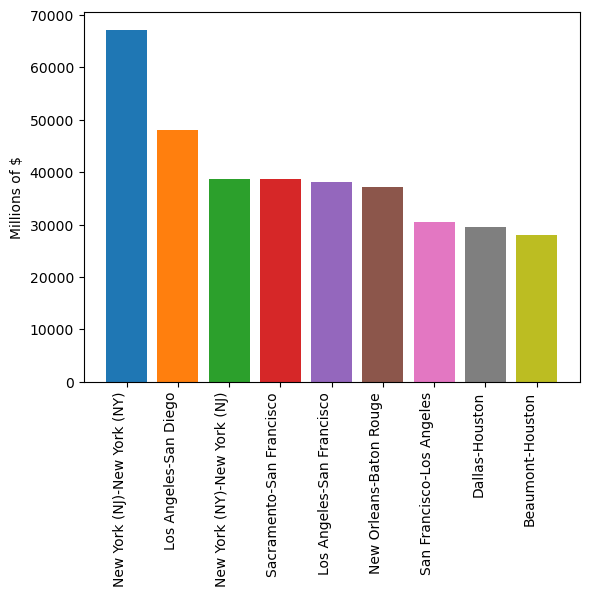

In [60]:
dms_pairs_total = dms_pairs.groupby(["pair", "abbr_orig", "abbr_dest"]).sum()["current_value_2022"].reset_index()
dms_pairs_total.sort_values(by=["current_value_2022"], ascending=False, inplace=True)

dms_top10_pairs_total = dms_pairs_total.iloc[:9]

def make_bar_chart(data):
    data_top10 = data.iloc[:9]
    plt.xticks(rotation=90, ha='right')
    plt.ylabel("Millions of $")

    for i in data_top10.index:
        row = data_top10.loc[i]
        plt.bar(row["pair"], row["current_value_2022"])

    plt.show()

make_bar_chart(dms_top10_pairs_total)

In [61]:
commodity_df

,Numeric Label,Description
0,1,Live animals/fish
1,2,Cereal grains
2,3,Other ag prods.
3,4,Animal feed
4,5,Meat/seafood
5,6,Milled grain prods.
6,7,Other foodstuffs
7,8,Alcoholic beverages
8,9,Tobacco prods.
9,10,Building stone


In [62]:
regions = {
    "west": ["CA", "OR", "WA", "NV", "ID", "UT", "CO", "WY", "MT", "HI", "AK"],
    "midwest": ["ND", "SD", "NE", "KS", "MN", "IA", "MO", "WI", "IL", "IN", "MI", "OH"],
    "southwest": ["AZ", "NM", "TX", "OK"],
    "southeast": ["AR", "LA", "MS", "TN", "AL", "KY", "GA", "WV", "VA", "NC", "SC", "FL", "MD", "DE"],
    "northeast": ["CT", "DC", "ME", "MA", "NH", "NJ", "NY", "PA", "RI", "VT"]
}

dms_data_regional = {label: dms_data[dms_data["abbr_orig"].isin(regions[label]) & dms_data["abbr_dest"].isin(regions[label])] for label in regions}
dms_pairs_regional = {}
for label in regions:
    data = dms_data_regional[label]
    data = data[data["dms_orig"] != data["dms_dest"]]
    data = data[(data["CFSMA_orig"] != 99999) & (data["CFSMA_dest"] != 99999)]
    data = data.groupby(["pair", "abbr_orig", "abbr_dest", "commodity_name", "sctg2", "short_placename_orig", "short_placename_dest"]).sum()["current_value_2022"].reset_index()
    dms_pairs_regional[label] = data
dms_pairs_regional["west"]

,pair,abbr_orig,abbr_dest,commodity_name,sctg2,short_placename_orig,short_placename_dest,current_value_2022
0,Denver-Fresno,CO,CA,Alcoholic beverages,8,Denver,Fresno,6.449645
1,Denver-Fresno,CO,CA,Animal feed,4,Denver,Fresno,1.052143
2,Denver-Fresno,CO,CA,Articles-base metal,33,Denver,Fresno,0.057836
3,Denver-Fresno,CO,CA,Base metals,32,Denver,Fresno,0.062023
4,Denver-Fresno,CO,CA,Basic chemicals,20,Denver,Fresno,11.901754
...,...,...,...,...,...,...,...,...
3470,Seattle-San Francisco,WA,CA,Printed prods.,29,Seattle,San Francisco,18.956765
3471,Seattle-San Francisco,WA,CA,Textiles/leather,30,Seattle,San Francisco,160.923633
3472,Seattle-San Francisco,WA,CA,Transport equip.,37,Seattle,San Francisco,40.159206
3473,Seattle-San Francisco,WA,CA,Waste/scrap,41,Seattle,San Francisco,0.048749


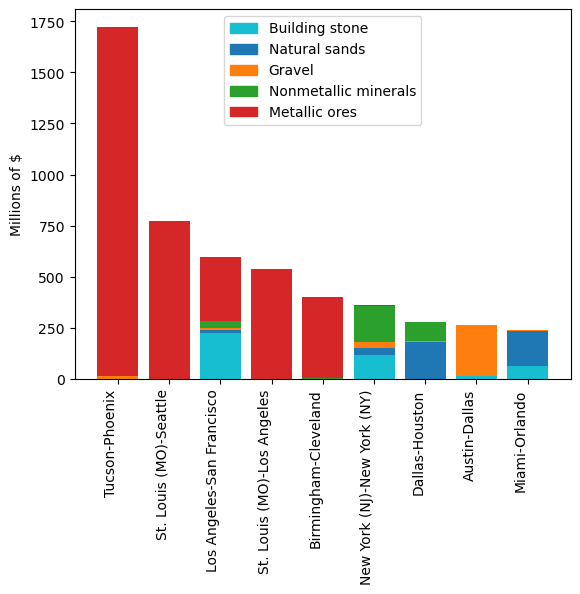

In [75]:
def make_commodity_bar_chart(data, commodity_names):
    colors = list(mclr.TABLEAU_COLORS)
    plt.xticks(rotation=90, ha='right')
    plt.ylabel("Millions of $")
    last = ""
    bottom = 0.0
    patches = {}
    color_labels = []

    data = data[data["commodity_name"].isin(commodity_names)]
    data_top10 = data.groupby(["pair", "abbr_orig", "abbr_dest"]).sum()["current_value_2022"].reset_index()
    data_top10.sort_values(by=["current_value_2022"], ascending=False, inplace=True)
    data_top10 = data_top10.iloc[:9]
    data_bycomod = data.groupby(["pair", "abbr_orig", "abbr_dest", "commodity_name", "sctg2"]).sum()["current_value_2022"].reset_index()
    data_bycomod = pd.merge(data_bycomod, data_top10.rename(columns={"current_value_2022": "total"}), on="pair")
    data_bycomod.sort_values(by=["total", "sctg2"], ascending=[False, True], inplace=True)

    for i in data_bycomod.index:
        row = data_bycomod.loc[i]
        if row["pair"] != last:
            last = row["pair"]
            plt.bar(row["pair"], row["current_value_2022"], bottom=0.0, color=colors[(int(row["sctg2"]) - 1) % len(colors)])
            bottom = row["current_value_2022"]
        else:
            plt.bar(row["pair"], row["current_value_2022"], bottom=bottom, color=colors[(int(row["sctg2"]) - 1) % len(colors)])
            bottom += row["current_value_2022"]
        patches[row["commodity_name"]] = colors[(int(row["sctg2"]) - 1) % len(colors)]

    for i in commodity_names:
        color_labels.append(plt.matplotlib.patches.Patch(color=patches[i], label=i))

    plt.legend(handles=color_labels, loc="upper center")
    plt.show()

commodities = [commodity_df.set_index(["Numeric Label"]).loc[i]["Description"] for i in range(10, 15)]
make_commodity_bar_chart(dms_pairs, commodities)

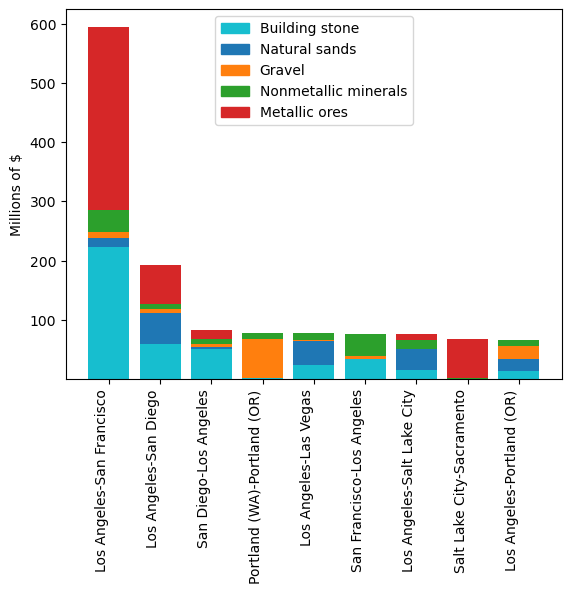

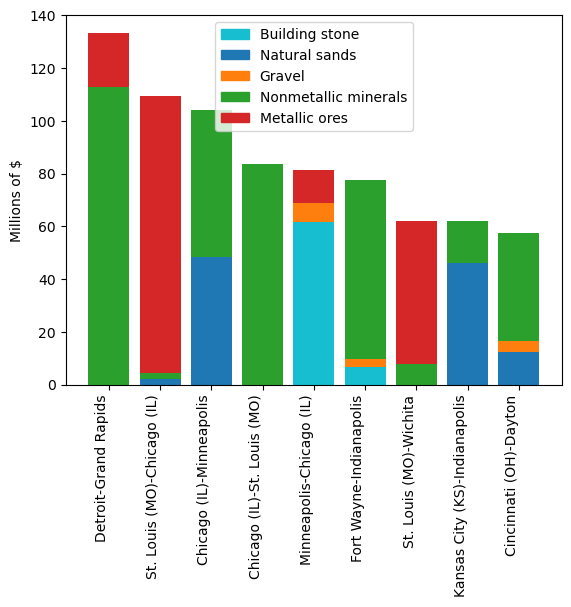

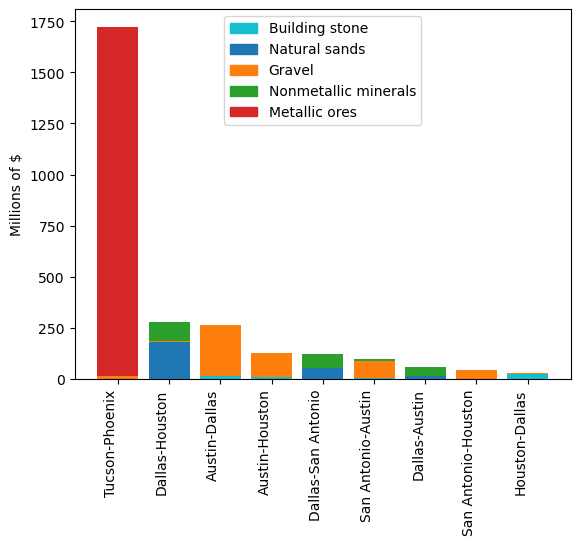

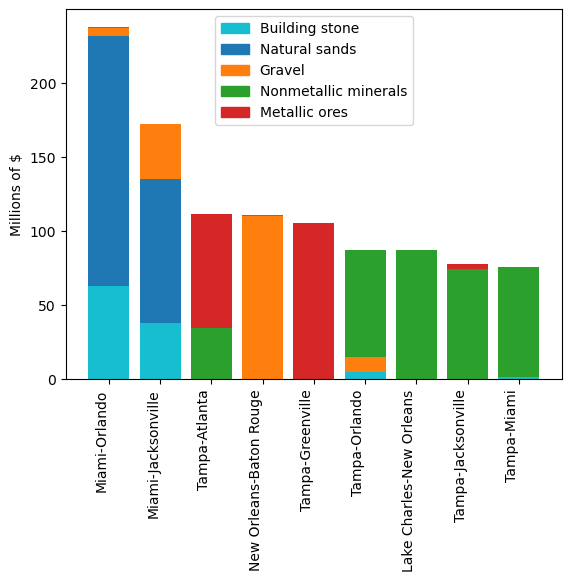

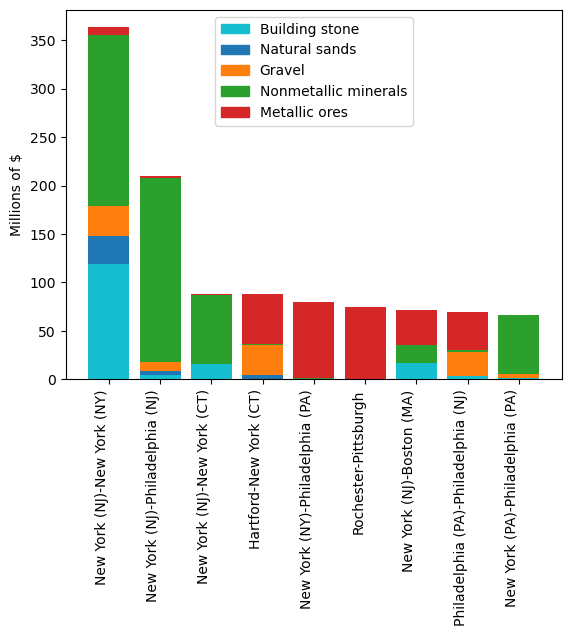

[None, None, None, None, None]

In [76]:
[make_commodity_bar_chart(dms_pairs_regional[label], commodities) for label in dms_pairs_regional]

/var/folders/rs/1b7d_4y96s39hlbsx0_qmqyw0000gn/T/ipykernel_6085/3145123701.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '11.914633' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adj_mat.loc[row["short_placename_orig"], row["short_placename_dest"]] = row["current_value_2022"]
/var/folders/rs/1b7d_4y96s39hlbsx0_qmqyw0000gn/T/ipykernel_6085/3145123701.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '41.607775' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adj_mat.loc[row["short_placename_orig"], row["short_placename_dest"]] = row["current_value_2022"]
/var/folders/rs/1b7d_4y96s39hlbsx0_qmqyw0000gn/T/ipykernel_6085/3145123701.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a futu

                   Denver    Fresno  Las Vegas  Los Angeles  Portland (OR)  \
Denver           0.000000   0.00000   0.000000    11.914633       0.000000   
Fresno           0.000000   0.00000   0.000000     0.000000       0.000000   
Las Vegas        0.000000   0.00000   0.000000    43.963798       0.000000   
Los Angeles     22.223320   0.00000  77.193101     0.000000      66.539897   
Portland (OR)    0.000000   0.00000   0.000000     0.000000       0.000000   
Portland (WA)    0.000000   0.00000   0.000000     0.000000      77.770189   
Sacramento       0.000000   0.00000   0.000000     0.000000       0.000000   
Salt Lake City  46.382407   0.00000   0.000000    12.275852      38.697883   
San Diego        0.000000   0.00000   0.000000    82.209714       0.000000   
San Francisco    0.000000  42.58296   0.000000    75.885862      15.487580   
Seattle          0.000000   0.00000   0.000000     0.000000      26.374605   

                Portland (WA)  Sacramento  Salt Lake City   San

NetworkXError: Graph is not strongly connected.

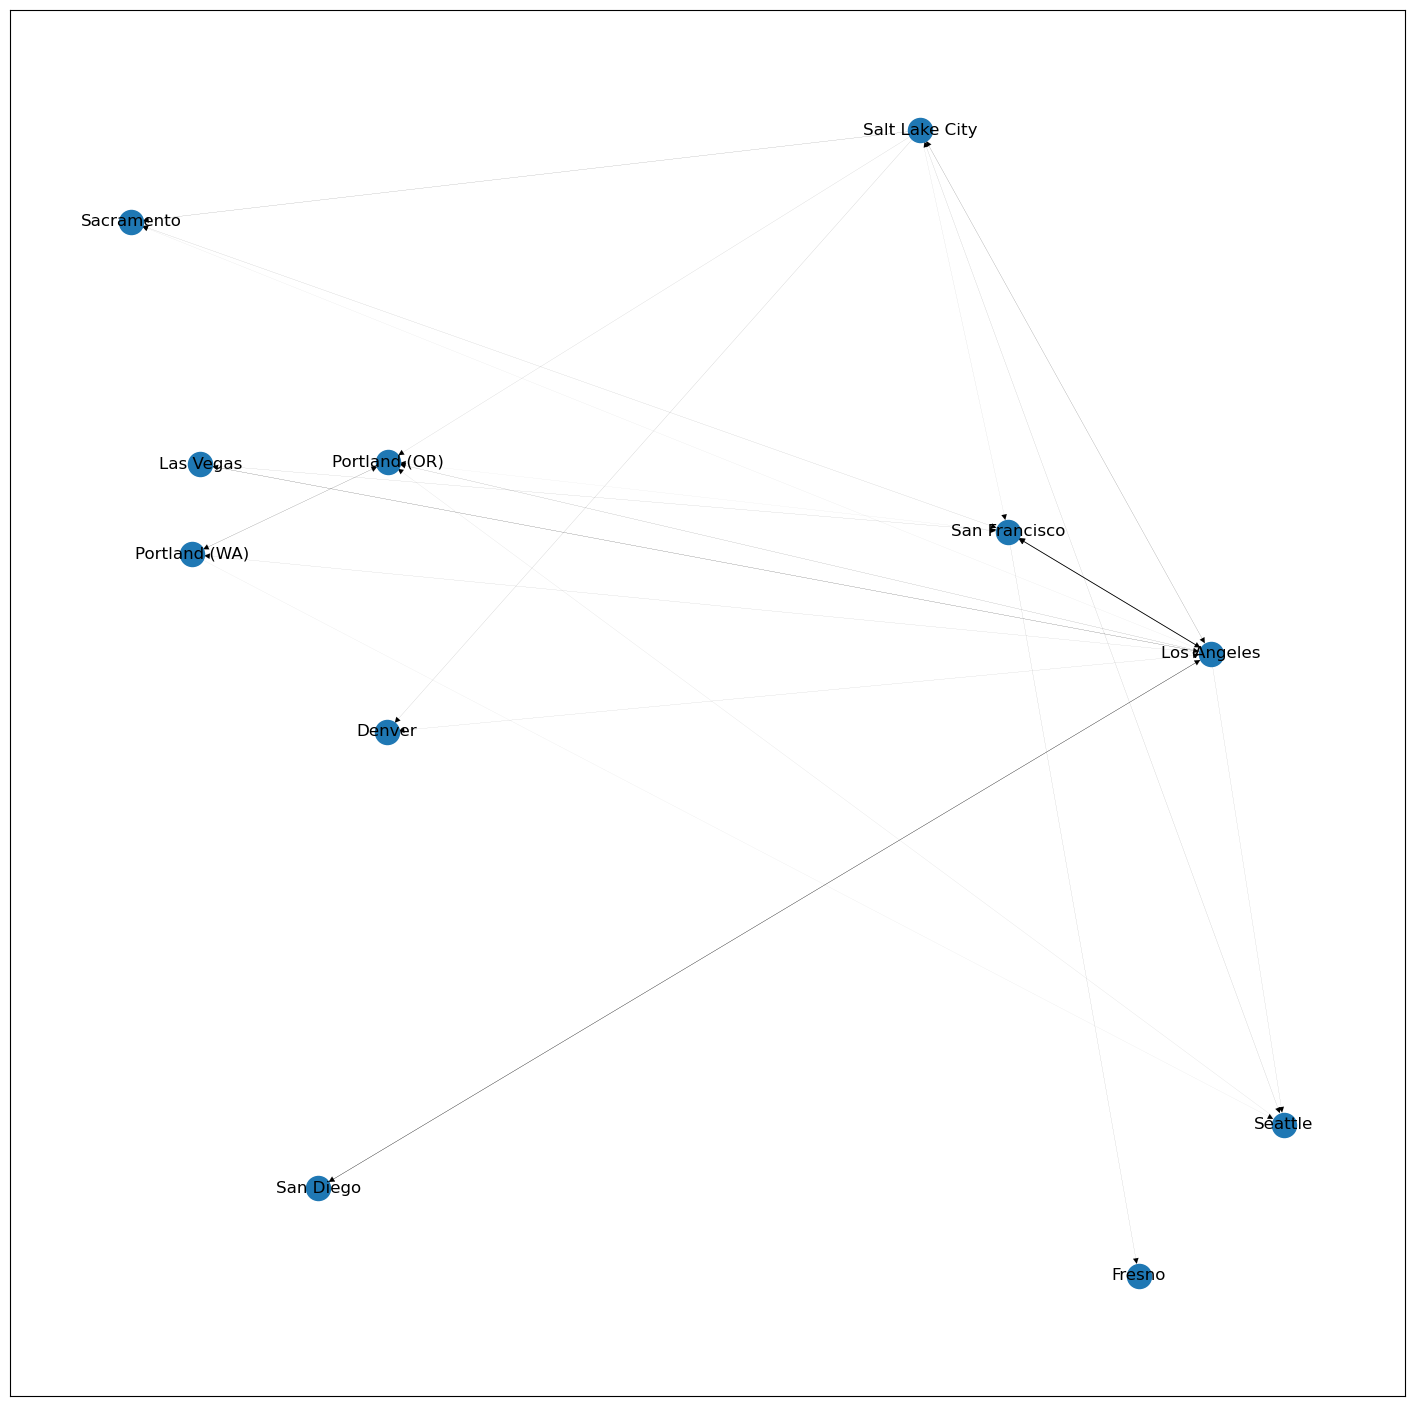

In [82]:
def make_network_graph(data, commodity_names, cutoff):
    data = data[data["commodity_name"].isin(commodity_names)]
    data_pairs = data.groupby(["pair", "short_placename_orig", "short_placename_dest"]).sum()["current_value_2022"].reset_index()
    data_pairs = data_pairs[data_pairs["current_value_2022"] > cutoff]
    placenames = np.unique(pd.concat([data_pairs["short_placename_orig"], data_pairs["short_placename_dest"]], axis=0))

    adj_mat = pd.DataFrame(index=placenames, columns=placenames, data=0)

    for i in data_pairs.index:
        row = data_pairs.loc[i]
        adj_mat.loc[row["short_placename_orig"], row["short_placename_dest"]] = row["current_value_2022"]

    print(adj_mat)

    G = nx.from_pandas_adjacency(df=adj_mat, create_using=nx.DiGraph())
    width = [adj_mat.loc[edge[0], edge[1]] / 1000 for edge in nx.edges(G)]
    plt.figure(figsize=(18,18))
    nx.draw_networkx(G, arrows=True, width=width, pos=nx.spring_layout(G, threshold=.03))
    plt.savefig("output.png", dpi=300)
    nx.set_edge_attributes(G, {edge: adj_mat.loc[edge[0], edge[1]] for edge in nx.edges(G)}, "weight")
    degree_hist = nx.degree_histogram(G)

    print("Nodes: " + str(len(G.nodes)))
    print("Degree Distribution: " + str(nx.degree_histogram(G)))
    print("Avg degree: " + str(sum([degree_hist[i] * i for i in range(len(degree_hist))]) / len(degree_hist)))
    print("Avg shortest path: " + str(nx.average_shortest_path_length(G)))
    print("Avg shortest path (weighted): " + str(nx.average_shortest_path_length(G, weight="weight")))
    print("Avg clustering coefficient: " + str(nx.average_clustering(G)))
    print("Avg clustering coefficient (weigthed): " + str(nx.average_clustering(G, weight="weight")))

# make_network_graph(dms_pairs_regional["midwest"], commodities, 10.0)
# plt.show()
make_network_graph(dms_pairs_regional["west"], commodities, 10.0)
plt.show()